In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, log_loss
import matplotlib.pyplot as plt

# Import dataset
df = pd.read_csv('card_transdata.csv')
display(df)
print(df.shape)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


(1000000, 8)


In [2]:
# Check for any data instances with missing values
df[df.isna().any(axis=1)]

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud


In [3]:
df =  df.sample(frac=1) # shuffle the dataset
X = df.iloc[:,[0, 1, 2, 3, 4, 5, 6]]
y = df.iloc[:,[7]]
display(X)
display(y)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
695721,2.009328,2.703990,0.400711,1.0,1.0,0.0,0.0
97894,378.457784,0.018842,3.215109,1.0,1.0,0.0,0.0
905175,4.690637,2.979507,4.331024,1.0,1.0,0.0,1.0
903511,22.197237,0.273489,0.745095,1.0,1.0,0.0,1.0
680039,2.200840,0.622766,0.274694,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
943003,1.679252,0.131232,0.360486,0.0,0.0,0.0,0.0
891205,2.976543,0.398596,0.302302,1.0,0.0,0.0,1.0
203599,0.296601,2.608456,1.335744,0.0,1.0,0.0,1.0
558244,99.086016,0.283419,0.462358,1.0,0.0,0.0,0.0


,fraud
695721,0.0
97894,0.0
905175,1.0
903511,0.0
680039,0.0
...,...
943003,0.0
891205,0.0
203599,0.0
558244,0.0


In [4]:
# using the train test split function (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(
  X, y, random_state=42, test_size=0.2, shuffle=False)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(X_train.head()) # check if x and y align to each data instance
print(y_train.head())

800000
800000
200000
200000
        distance_from_home  distance_from_last_transaction  \
695721            2.009328                        2.703990   
97894           378.457784                        0.018842   
905175            4.690637                        2.979507   
903511           22.197237                        0.273489   
680039            2.200840                        0.622766   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
695721                        0.400711              1.0        1.0   
97894                         3.215109              1.0        1.0   
905175                        4.331024              1.0        1.0   
903511                        0.745095              1.0        1.0   
680039                        0.274694              1.0        0.0   

        used_pin_number  online_order  
695721              0.0           0.0  
97894               0.0           0.0  
905175              0.0           1.0  
903511            

In [5]:
# Define SGDClassifer using log loss
model = SGDClassifier(loss='log_loss')

# Train the model
model.fit(X_train, y_train)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(loss='log_loss')

In [6]:
# Show parameters (including intercept)
parameters = list(model.coef_[0])
parameters.insert(0, model.intercept_[0])
print("Parameters: %s" % parameters)

# Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Class probabilities for log loss function
train_pred_proba = model.predict_proba(X_train)
test_pred_proba = model.predict_proba(X_test)

Parameters: [-154.23753587141601, 0.10106580221238112, 0.19434402298385847, 5.736744267037442, 33.80361214542557, -4.285505338796722, -25.782686518747543, 97.90542452620629]


In [7]:
# Evaluation metrics

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
train_sensitivity = recall_score(y_train, train_pred, average='binary', pos_label=1)
test_sensitivity = recall_score(y_test, test_pred, average='binary', pos_label=1)
train_specificity = recall_score(y_train, train_pred, average='binary', pos_label=0)
test_specificity = recall_score(y_test, test_pred, average='binary', pos_label=0)
train_f1 = f1_score(y_train, train_pred, average='binary')
test_f1 = f1_score(y_test, test_pred, average='binary')
train_logloss = log_loss(y_train, train_pred_proba)
test_logloss = log_loss(y_test, test_pred_proba)

In [8]:
# To print out evaluation metrics
metric = {
    'Metrics': ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'Log Loss'],
    'Training': [train_accuracy, train_sensitivity, train_specificity, train_f1, train_logloss],
    'Test' : [test_accuracy, test_sensitivity, test_specificity, test_f1, test_logloss]
}

# Replace header by the first row
metric = pd.DataFrame(metric).T
metric.columns = metric.iloc[0]
metric = metric[1:]
display(metric)

Metrics,Accuracy,Sensitivity,Specificity,F1 Score,Log Loss
Training,0.960661,0.745392,0.98128,0.768113,0.520649
Test,0.95992,0.738727,0.981098,0.763093,0.530255


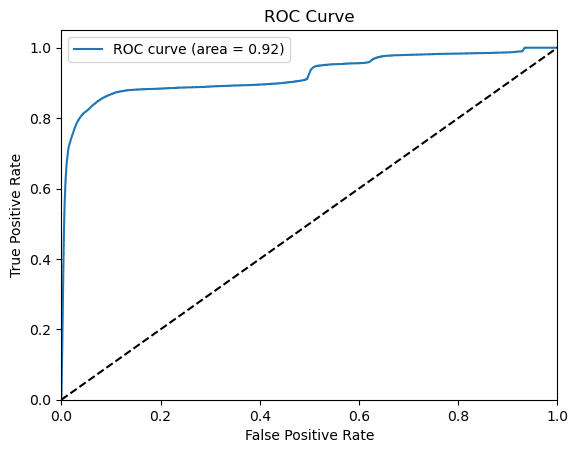

In [9]:
# Plotting ROC Curve (AUC)
test_class_1_prob = test_pred_proba[:,1] # get the probabilites of class 1 to be labeled
fpr, tpr, threshold = metrics.roc_curve(y_test, test_class_1_prob)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()